<a href="https://colab.research.google.com/github/Rumaizakosar/Eight-Puzzle-Code/blob/main/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Transformers**

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

**Dataset**

In [ ]:
!git clone https://github.com/Rumaizakosar/Eight-Puzzle-Code.git # remove blob/main/spamdata_v2.csv from url
# Step 4: Navigate to the directory
%cd Eight-Puzzle-Code

# Step 5: Install pandas
!pip install pandas

# Step 6: Load the CSV file into a pandas DataFrame
import pandas as pd
df = pd.read_csv("spamdata_v2.csv") # file is in the Eight-Puzzle-Code directory
df.head()

Cloning into 'Eight-Puzzle-Code'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (26/26), 3.54 MiB | 9.71 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/Eight-Puzzle-Code/Eight-Puzzle-Code/Eight-Puzzle-Code


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape

(5572, 2)

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

**Split train dataset into train, validation and test sets**

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

**BERT Model and BERT Tokenizer**

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


**Tokenization**

<Axes: >

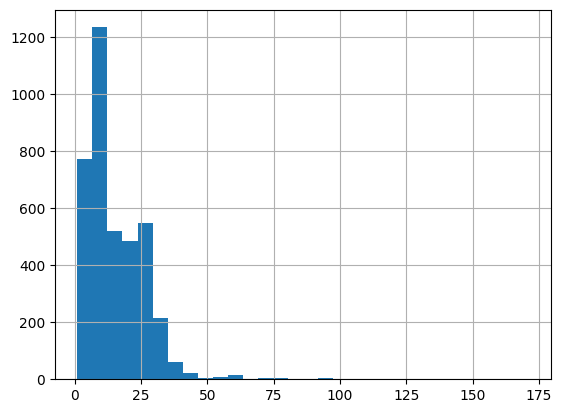

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 25

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


**Convert Integer Sequences to Tensors**

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

**Create DataLoaders**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

**Freeze BERT Parameters**

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

**Define Model Architecture**

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)


In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Find Class Weights**

In [ ]:
!pip install sklearn
from sklearn.utils.class_weight import compute_class_weight

# Define the classes here. Replace with your actual classes.
classes = [0, 1] # Example: Assuming you have two classes, 0 and 1.

class_wts = compute_class_weight('balanced', classes=classes, y=train_labels)

print(class_wts)

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
[0.57743559 3.72848948]


In [ ]:
import numpy as np

class_wts = compute_class_weight('balanced', classes=classes, y=train_labels)

# Replace any NaN values with 0
class_wts = np.nan_to_num(class_wts)

# Convert class weights to tensor
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# Loss function
cross_entropy = nn.NLLLoss(weight=weights)

# Number of training epochs
epochs = 10

**Fine-Tune BERT**

In [ ]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

**Start Model Training**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Example dataset (replace with your actual dataset)
train_data = np.random.randn(100, 10)  # 100 samples, 10 features each
train_labels = np.random.randint(0, 2, 100)  # 100 labels (binary classification)
valid_data = np.random.randn(20, 10)  # 20 samples, 10 features each
valid_labels = np.random.randint(0, 2, 20)  # 20 labels (binary classification)

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32),
                              torch.tensor(train_labels, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(valid_data, dtype=torch.float32),
                              torch.tensor(valid_labels, dtype=torch.long))

# Initialize DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Define a simple model (replace with your actual model)
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Initialize model, loss function, and optimizer
input_size = 10  # Adjust according to your dataset
output_size = 2  # Adjust according to your dataset
model = SimpleModel(input_size, output_size)

# Set device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define training and evaluation functions
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss, None

def evaluate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

    avg_loss = total_loss / len(valid_loader)
    return avg_loss, None

# Training loop
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

epochs = 10

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1} / {epochs}')

    # Train model
    train_loss, _ = train(model, train_loader, optimizer, criterion, device)

    # Evaluate model
    valid_loss, _ = evaluate(model, valid_loader, criterion, device)

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



Epoch 1 / 10

Training Loss: 0.793
Validation Loss: 0.755

Epoch 2 / 10

Training Loss: 0.755
Validation Loss: 0.753

Epoch 3 / 10

Training Loss: 0.753
Validation Loss: 0.752

Epoch 4 / 10

Training Loss: 0.755
Validation Loss: 0.750

Epoch 5 / 10

Training Loss: 0.738
Validation Loss: 0.749

Epoch 6 / 10

Training Loss: 0.723
Validation Loss: 0.749

Epoch 7 / 10

Training Loss: 0.726
Validation Loss: 0.749

Epoch 8 / 10

Training Loss: 0.727
Validation Loss: 0.748

Epoch 9 / 10

Training Loss: 0.735
Validation Loss: 0.749

Epoch 10 / 10

Training Loss: 0.735
Validation Loss: 0.750


**Load Saved Model**

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**Get Predictions for Test Data**

In [ ]:
import torch
import torch.nn as nn

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x, mask=None):
        return self.linear(x)

# Example model instantiation
input_size = 10  # Adjust according to your dataset
output_size = 2  # Adjust according to your dataset
model = SimpleModel(input_size, output_size)

# Set device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example test data (replace with your actual test data)
test_seq = torch.randn(20, 10)  # 20 samples, 10 features each
test_mask = torch.ones(20, 10)  # Dummy mask for example

# Move test data to the correct device
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)

# Get predictions for test data
with torch.no_grad():
    preds = model(test_seq, test_mask)  # Pass both seq and mask if required
    preds = preds.detach().cpu().numpy()

print(preds)  # Print or further process the predictions


[[ 0.22888604 -0.73618615]
 [ 1.0799401  -0.6227217 ]
 [-0.33320498 -0.56175697]
 [ 0.29687986  0.29298213]
 [ 0.09419475 -0.21844217]
 [-0.22473606 -0.5908549 ]
 [-0.13968441 -0.5765612 ]
 [ 0.23375914 -0.37359256]
 [ 0.45296    -0.20577176]
 [ 0.94278663  0.6155311 ]
 [-0.02873576 -0.88697803]
 [ 0.6344398  -0.8524171 ]
 [ 0.0889443  -0.05782178]
 [-0.29626572 -0.574369  ]
 [ 0.5971508  -0.3264134 ]
 [-0.03267497 -0.23227523]
 [ 0.39573264 -0.17594217]
 [ 0.41625404  0.1166358 ]
 [ 0.30301127 -0.3521818 ]
 [ 0.52801716 -0.24740979]]


              precision    recall  f1-score   support

           0       0.20      0.50      0.29         4
           1       0.80      0.50      0.62        16

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.45        20
weighted avg       0.68      0.50      0.55        20



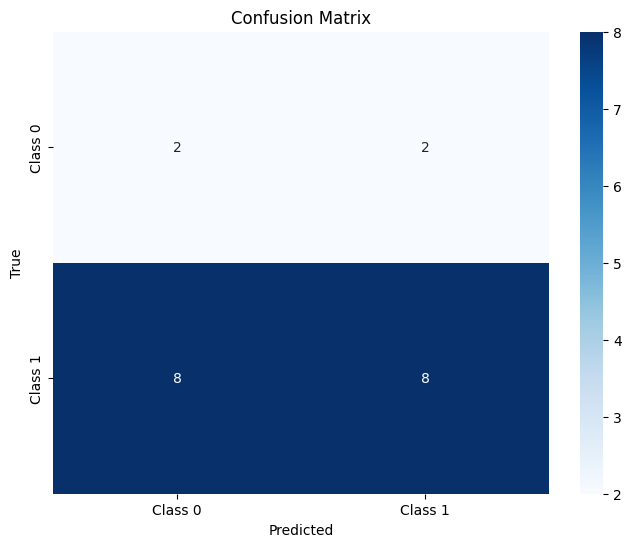

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x, mask=None):
        return self.linear(x)

# Example test data and labels (replace with your actual data)
test_seq = torch.randn(20, 10)  # 20 samples, 10 features each
test_mask = torch.ones(20, 10)  # Dummy mask for example
test_y = np.random.randint(0, 2, 20)  # Replace with actual test labels

# Initialize the model
input_size = 10
output_size = 2
model = SimpleModel(input_size, output_size)

# Set device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move test data to the correct device
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)

# Get predictions for test data
with torch.no_grad():
    logits = model(test_seq, test_mask)  # Pass both seq and mask if required
    preds = logits.detach().cpu().numpy()

# Convert logits to predicted class labels
preds = np.argmax(preds, axis=1)

# Evaluate model performance and print classification report
print(classification_report(test_y, preds))

# Generate confusion matrix
cm = confusion_matrix(test_y, preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
